### Oxygen Evals in Saanich Inlet

In [1]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import cmocean.cm as cm
import matplotlib.patches as mpatches
import scipy.stats as stat
from matplotlib.colors import LogNorm

In [2]:
mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202108.nc')

meshb = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
bathyb = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc')
grid = xr.open_dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc', mask_and_scale=False)

depthb = meshb.variables['gdept_0'][:]
with xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc') as mesh:
    tmask = mesh.tmask
    mbathy = mesh.mbathy
    long = mesh.nav_lon
    latg = mesh.nav_lat
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)

In [3]:
# matched data
pnw202111_12 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202111/ObsModel_202111_pnw_20120101_20121231.csv')
pnw202410_12 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410_pnw_20120101_20121231.csv')
pnw202111_13 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202111/ObsModel_202111_pnw_20130101_20131231.csv')
pnw202410_13 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410_pnw_20130101_20131231.csv')
pnw202111_14 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202111/ObsModel_202111_pnw_20140101_20141231.csv')
pnw202410_14 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410_pnw_20140101_20141231.csv')

df202111 = pd.concat([pnw202111_12, pnw202111_13, pnw202111_14
                       ], ignore_index=True)
df202410 = pd.concat([pnw202410_12, pnw202410_13, pnw202410_14
                       ], ignore_index=True)


/tmp/ipykernel_780394/2517360630.py:4: UserWarning: linewidths is ignored by contourf
  ax.contourf(long, latg, mbathy[0,:,:], linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')


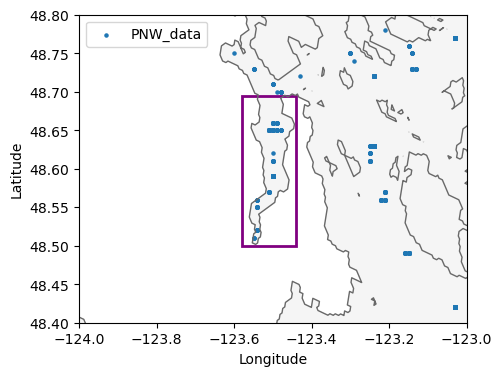

In [4]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
lon1,lon2,lat1,lat2 = (-123.58,-123.44,48.5,48.695)

ax.contourf(long, latg, mbathy[0,:,:], linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(long, latg, mbathy[0,:,:], linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([48.4,48.8])
ax.set_xlim([-124,-123])

# plot the location of observations
ax.scatter(df202111.Lon, df202111.Lat, s=5, label="PNW_data")

ax.legend()

left, bottom, width, height = (lon2, lat1, lon1-lon2, lat2-lat1)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        #alpha=0.1
                        color="purple",
                       linewidth=2,
                       label="Puget Sound")

plt.gca().add_patch(rect)

In [5]:
df_21 = df202111[ df202111['Lon'].between(lon1, lon2) & df202111['Lat'].between(lat1, lat2) ]
df_24 = df202410[ df202410['Lon'].between(lon1, lon2) & df202410['Lat'].between(lat1, lat2) ]


In [6]:
def calc_stats(x, y):
    stats = {}
    MSE = np.mean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.mean(y) - np.mean(x)
    stats['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    
    return stats


def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.01, 0.8, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

In [7]:
def profiles(tracer,colour,ax):
    if tracer == 'Salinity':
        t_obs = 'SA'
        t_mod = 'mod_vosaline'
        unit = 'g/kg'
        unity ='meter'
    elif tracer == 'Temperature':
        t_obs = 'Temp'
        t_mod = 'mod_votemper'
        unit = '°C'
        unity ='meter'
    elif tracer == 'NO3':
        t_obs = 'NO3 (uM)'
        t_mod = 'mod_nitrate'
        unit = 'uM'
        unity ='meter'
    elif tracer == 'NH4':
        t_obs = 'NH4'
        t_mod = 'mod_ammonium'
        unit = 'uM'
        unity ='meter'
    elif tracer == 'DO':
        t_obs = 'Oxygen_Dissolved'
        t_mod = 'mod_dissolved_oxygen'
        unit = 'uM'
        unity ='meter'

    avg_obs, binsa, _ = stat.binned_statistic(-df_21['Z'][(np.isfinite(df_21[t_obs]))],df_21[t_obs][(np.isfinite(df_21[t_obs]))],statistic='mean',bins=8)
    avg_21, bins, _ = stat.binned_statistic(-df_21['Z'][(np.isfinite(df_21[t_mod]))],df_21[t_mod][(np.isfinite(df_21[t_mod]))],statistic='mean',bins=8)
    avg_24, binsa, _ = stat.binned_statistic(-df_24['Z'][(np.isfinite(df_24[t_mod]))],df_24[t_mod][(np.isfinite(df_24[t_mod]))],statistic='mean',bins=8)

    ax.plot(avg_obs, binsa[:-1], lw=2,label='obs')
    ax.plot(avg_21, bins[:-1], lw=2,label='202111')
    ax.plot(avg_24, binsa[:-1], lw=2,label='202410')

    title = tracer
    #ax.set_title(title)
    ax.set_xlabel(unit)
    ax.set_ylabel(unity)

In [8]:
def prop_prop(ax,stringX,stringY,x,y,binX,binY):
    cmap = cm.rain
    cmap.set_bad('w')
    # cmap.set_extremes(under='w')

    bins = [binX,binY]
    H, xedges, yedges=np.histogram2d(x,y,bins=bins)
    H = H.T
    H_final = np.where(H>0, H, H*np.nan)
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, cmap=cmap, norm=LogNorm(vmin=10, vmax=45000))
    ax.set_ylabel(stringY)
    ax.set_xlabel(stringX)

2012-2014


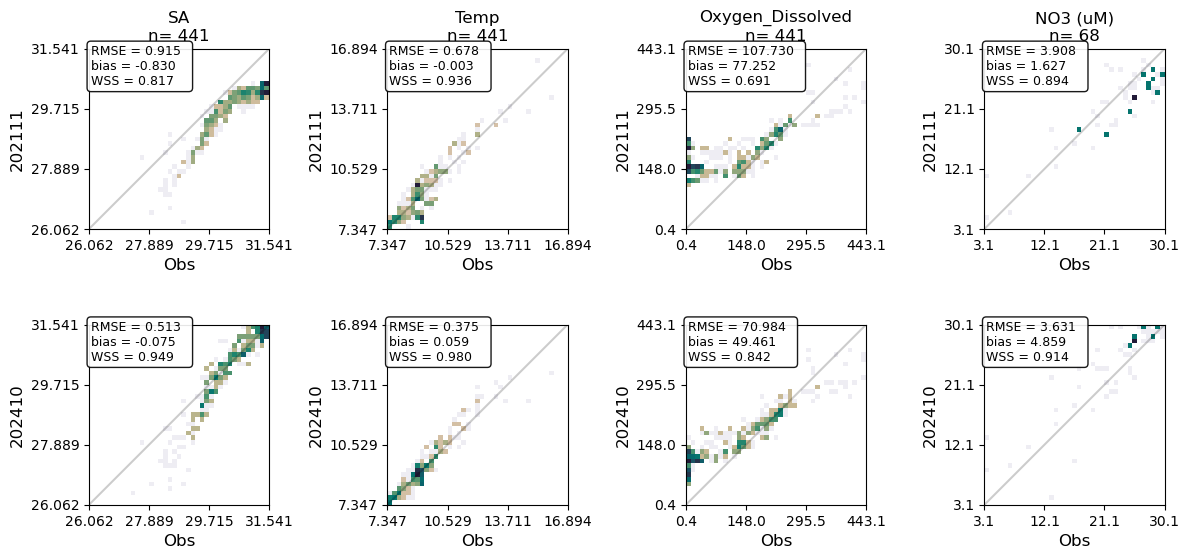

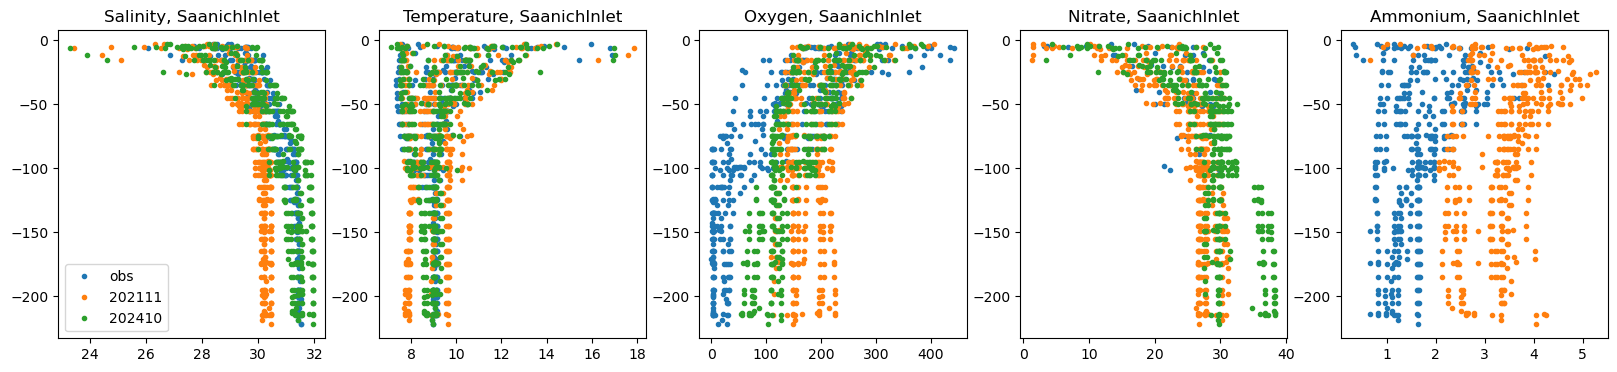

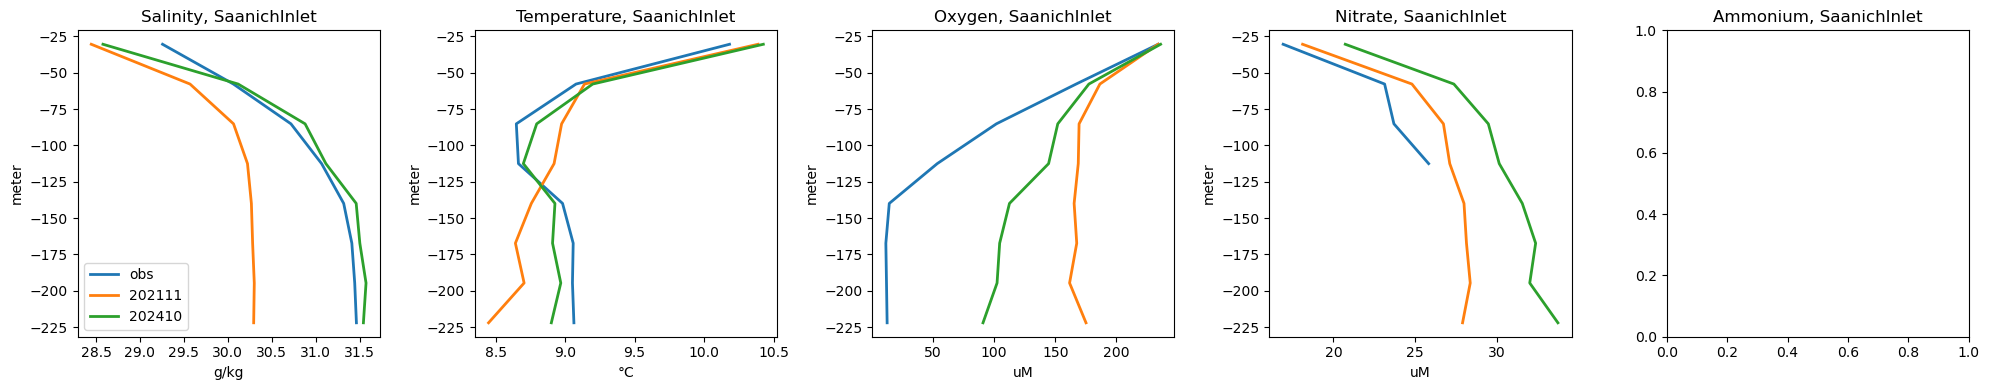

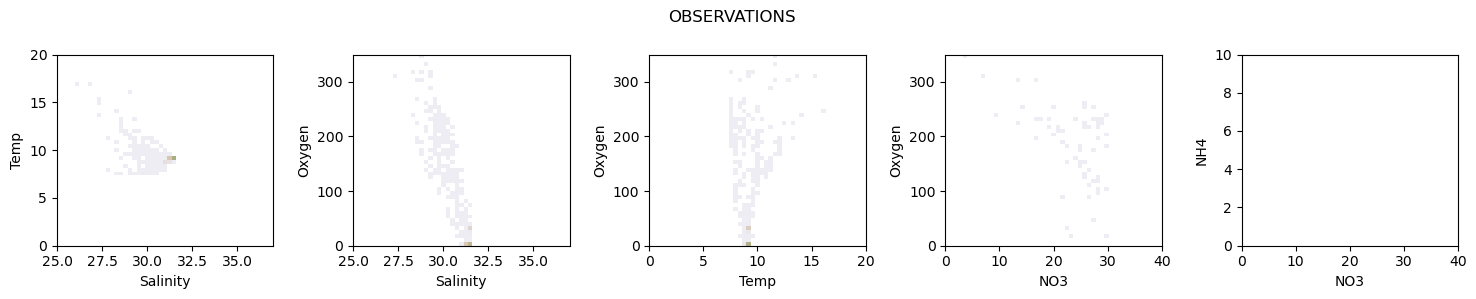

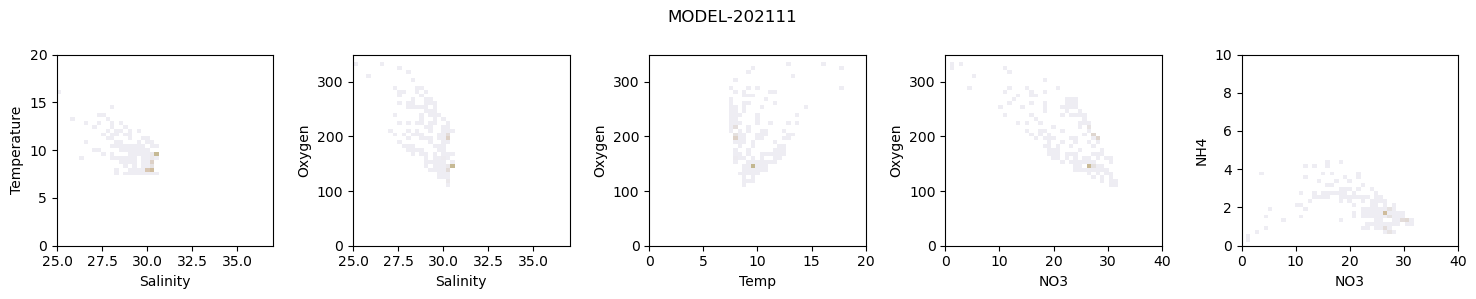

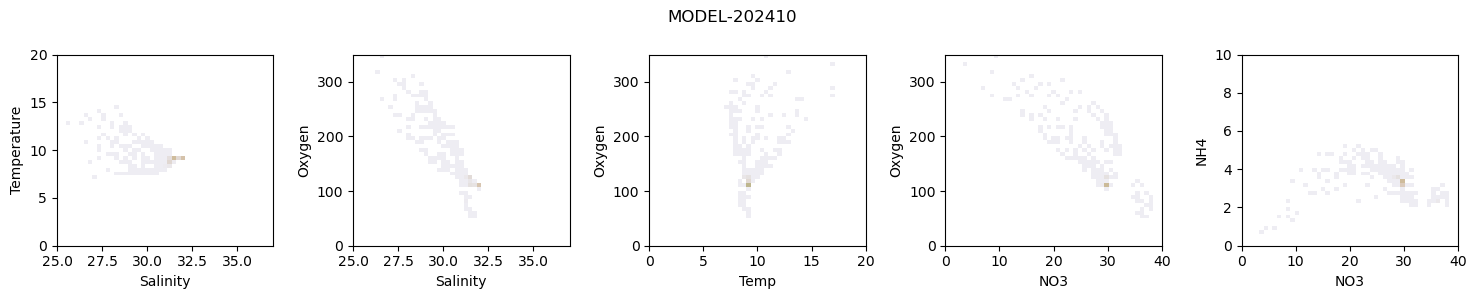

In [13]:
print('2012-2014')
tracers_obs = ['SA', 'Temp', 'Oxygen_Dissolved', 'NO3 (uM)']#, 'NH4'] 
tracers_mod = ['mod_vosaline', 'mod_votemper', 'mod_dissolved_oxygen', 'mod_nitrate']#, 'mod_ammonium'] 
dff = list([df_21,df_24])
cmap = cm.rain
mod = ['202111','202410']
fig, axs = plt.subplots(len(dff), len(tracers_obs), figsize = (3*len(tracers_obs), 6)) 

for i in range(len(tracers_obs)):
    for j in range(2):
        df=dff[j]
        vmin, vmax = np.min(df[tracers_obs[i]]), np.max(df[tracers_obs[i]])
        bin = np.linspace(vmin,vmax,40)

        axs[j,i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

        iiS=(~np.isnan(df[tracers_obs[i]]))&(~np.isnan(df[tracers_mod[i]]))

        counts, xedges, yedges, m2=axs[j,i].hist2d(df.loc[iiS,[tracers_obs[i]]].values.flatten(),
                                        df.loc[iiS,[tracers_mod[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

        ntick=np.linspace(vmin, vmax, 4)
        axs[j,i].set_xticks(ntick)
        axs[j,i].set_yticks(ntick)
        
        axs[j,i].set_aspect(1, adjustable='box')
        axs[j,i].set_ylabel(f'{mod[j]}',fontsize=12)
        axs[j,i].set_xlabel('Obs',fontsize=12)

        title = tracers_obs[i]+'\nn= '+str(np.count_nonzero(~np.isnan(df[tracers_obs[i]])))
        axs[0,i].set_title(title,fontsize=12)

    # plot the stats pannel
        plot_panel(axs[j,i], df[tracers_obs[i]], df[tracers_mod[i]], (vmin,vmax), ' ')

plt.tight_layout()

###############################################

i, j, k, l, m = (0, 1, 2, 3, 4)
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
title = 'Salinity, SaanichInlet'
ax[i].set_title(title,fontsize=12)
title = 'Temperature, SaanichInlet'
ax[j].set_title(title,fontsize=12)
title = 'Oxygen, SaanichInlet'
ax[k].set_title(title,fontsize=12)
title = 'Nitrate, SaanichInlet'
ax[l].set_title(title,fontsize=12)
title = 'Ammonium, SaanichInlet'
ax[m].set_title(title,fontsize=12)
ax[i].plot(df_24.SA, -df_24.Z, '.',label='obs')
ax[i].plot(df_21.mod_vosaline, -df_21.Z, '.', label='202111')
ax[i].plot(df_24.mod_vosaline, -df_24.Z, '.', label='202410')
ax[i].legend()
ax[j].plot(df_24.Temp, -df_24.Z, '.',label='obs')
ax[j].plot(df_21.mod_votemper, -df_21.Z, '.', label='202111')
ax[j].plot(df_24.mod_votemper, -df_24.Z, '.', label='202410')
ax[k].plot(df_24.Oxygen_Dissolved, -df_24.Z, '.',label='obs')
ax[k].plot(df_21.mod_dissolved_oxygen, -df_21.Z, '.', label='202111')
ax[k].plot(df_24.mod_dissolved_oxygen, -df_24.Z, '.', label='202410')
ax[l].plot(df_24['NO3 (uM)'], -df_24.Z, '.',label='obs')
ax[l].plot(df_21.mod_nitrate, -df_21.Z, '.', label='202111')
ax[l].plot(df_24.mod_nitrate, -df_24.Z, '.', label='202410')
#ax[m].plot(df_24.NH4, -df_24.Z, '.',label='obs')
ax[m].plot(df_21.mod_ammonium, -df_21.Z, '.', label='202111')
ax[m].plot(df_24.mod_ammonium, -df_24.Z, '.', label='202410')

fig, ax = plt.subplots(1, 5, figsize=(20,4))

title = 'Salinity, SaanichInlet'
ax[i].set_title(title,fontsize=12)
title = 'Temperature, SaanichInlet'
ax[j].set_title(title,fontsize=12)
title = 'Oxygen, SaanichInlet'
ax[k].set_title(title,fontsize=12)
title = 'Nitrate, SaanichInlet'
ax[l].set_title(title,fontsize=12)
title = 'Ammonium, SaanichInlet'
ax[m].set_title(title,fontsize=12)

# plot profiles

profiles('Salinity','k',ax[0])
profiles('Temperature','k',ax[1])
profiles('DO','k',ax[2])
profiles('NO3','k',ax[3])
#profiles('NH4','k',ax[4])
ax[0].legend()
plt.tight_layout()

######################################
# obs versus model property property plots
#set consistent bins
Tbin = np.linspace(0,20,50)
Sbin = np.linspace(25,37,50)
Dbin = np.linspace(0,350,50)
Nbin = np.linspace(0,40,50)
Hbin = np.linspace(0,10,50)

fig, axs = plt.subplots(1, 5, figsize = (15, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temp",df_21.SA,df_21.Temp,Sbin,Tbin)
prop_prop(axs[1],"Salinity","Oxygen",df_21.SA,df_21["Oxygen_Dissolved"],Sbin,Dbin)
prop_prop(axs[2],"Temp","Oxygen",df_21.Temp,df_21["Oxygen_Dissolved"],Tbin,Dbin)
prop_prop(axs[3],"NO3","Oxygen",df_21['NO3 (uM)'],df_21["Oxygen_Dissolved"],Nbin,Dbin)
prop_prop(axs[4],"NO3","NH4",df_21['NO3 (uM)'],df_21["NH4"],Nbin,Hbin)
fig.suptitle('OBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 5, figsize = (15, 3)) 

prop_prop(axs[0],"Salinity","Temperature",df_21.mod_vosaline,df_21.mod_votemper,Sbin,Tbin)
prop_prop(axs[1],"Salinity","Oxygen",df_21.mod_vosaline,df_21['mod_dissolved_oxygen'],Sbin,Dbin)
prop_prop(axs[2],"Temp","Oxygen",df_21.mod_votemper,df_21['mod_dissolved_oxygen'],Tbin,Dbin)
prop_prop(axs[3],"NO3","Oxygen",df_21['mod_nitrate'],df_21["mod_dissolved_oxygen"],Nbin,Dbin)
prop_prop(axs[4],"NO3","NH4",df_21['mod_nitrate'],df_21["mod_ammonium"],Nbin,Hbin)
fig.suptitle('MODEL-202111')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 5, figsize = (15, 3)) 

prop_prop(axs[0],"Salinity","Temperature",df_24.mod_vosaline,df_24.mod_votemper,Sbin,Tbin)
prop_prop(axs[1],"Salinity","Oxygen",df_24.mod_vosaline,df_24['mod_dissolved_oxygen'],Sbin,Dbin)
prop_prop(axs[2],"Temp","Oxygen",df_24.mod_votemper,df_24['mod_dissolved_oxygen'],Tbin,Dbin)
prop_prop(axs[3],"NO3","Oxygen",df_24['mod_nitrate'],df_24["mod_dissolved_oxygen"],Nbin,Dbin)
prop_prop(axs[4],"NO3","NH4",df_24['mod_nitrate'],df_24["mod_ammonium"],Nbin,Hbin)
fig.suptitle('MODEL-202410')

plt.tight_layout()